In [1]:
import torch
import os
from torchvision import datasets, transforms
import torch.nn as nn
import torchvision
import numpy as np
from matplotlib import pyplot as plt
from utils import plot_tsne, tensors_as_images, dataset_first_n, plot_fit
import random
import argparse
import itertools

import IPython.display


import cifar_nets
import training

NUM_CLASSES = 10
EPOCHS = 100

In [2]:
def freeze_seeds(seed=0):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)


In [3]:
args = argparse.Namespace()
args.seed = 0
args.data_path = "/datasets/cv_datasets/data"
args.batch_size = 32
args.latent_dim = 128
args.device = 'cuda' if torch.cuda.is_available() else 'cpu'
args.mnist = False
args.self_supervised = False

In [4]:
freeze_seeds(args.seed)

In [5]:

if args.mnist:
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.1307], std=[0.3081])  
    ])
    train_dataset = datasets.MNIST(root=args.data_path, train=True, download=True, transform=transform)
    test_dataset = datasets.MNIST(root=args.data_path, train=False, download=True, transform=transform)
else:
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.4914, 0.4822, 0.4465], std=[0.247, 0.243, 0.261])  
    ])
    train_dataset = datasets.CIFAR10(root=args.data_path, train=True, download=True, transform=transform)
    test_dataset = datasets.CIFAR10(root=args.data_path, train=False, download=True, transform=transform)

Files already downloaded and verified
Files already downloaded and verified


(<Figure size 1000x1000 with 10 Axes>,
 array([<Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >,
        <Axes: >, <Axes: >, <Axes: >, <Axes: >], dtype=object))

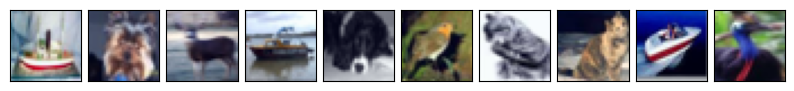

In [6]:

dataset_first_n(train_dataset, 10, figsize=(10,10), nrows=1)

In [7]:


#Data
# When you create your dataloader you should split train_dataset or test_dataset to leave some aside for validation
ds_val, ds_train = torch.utils.data.random_split(train_dataset, [0.2, 0.8])

# ds_train = torch.utils.data.Subset(ds_train, range(100))


dl_train = torch.utils.data.DataLoader(ds_train, batch_size=args.batch_size, shuffle=True)
dl_val = torch.utils.data.DataLoader(ds_val, batch_size=args.batch_size, shuffle=False)
dl_test = torch.utils.data.DataLoader(test_dataset, batch_size=args.batch_size, shuffle=False)

dl_sample = itertools.cycle(torch.utils.data.DataLoader(ds_train, batch_size=7, shuffle=True))

img_shape = train_dataset[0][0].shape



In [8]:
# model_dp

# m = torchvision.models.resnet50()
# m.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
# m.fc = nn.Linear(m.fc.in_features, args.latent_dim)
# encoder = m



In [9]:
# # Unfreeze only conv1 + layer1 + fc
# for name, param in m.named_parameters():
#     if "conv1" in name or "layer1" in name or "fc" in name:
#         param.requires_grad = True  # Allow training
#     else:
#         param.requires_grad = False  # Keep frozen


In [10]:
#Model
encoder = cifar_nets.Reg_Encoder(img_shape[0], args.latent_dim)
classifier = cifar_nets.Reg_Classifier(encoder,args.latent_dim, NUM_CLASSES).to(args.device)
# classifier_dp = torch.nn.DataParallel(classifier)

#Optimizer
optimizer = torch.optim.Adam(classifier.parameters())

#Loss
loss_fn = torch.nn.CrossEntropyLoss()

#Trainer
trainer = training.ClassifierTrainer(classifier, loss_fn, optimizer, args.device)

checkpoint_file = 'checkpoints/cifar_ete_classifier'
checkpoint_file_final = f'{checkpoint_file}_final'
if os.path.isfile(f'{checkpoint_file}.pt'):
    os.remove(f'{checkpoint_file}.pt')

In [11]:
classifier

Reg_Classifier(
  (encoder): Reg_Encoder(
    (encoder): Sequential(
      (0): Conv2d(3, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (1): LeakyReLU(negative_slope=0.01)
      (2): Dropout(p=0.3, inplace=False)
      (3): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (4): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (5): LeakyReLU(negative_slope=0.01)
      (6): Dropout(p=0.3, inplace=False)
      (7): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (8): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (9): LeakyReLU(negative_slope=0.01)
      (10): Dropout(p=0.3, inplace=False)
      (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (12): Flatten(start_dim=1, end_dim=-1)
      (13): Linear(in_features=2048, out_features=128, bias=True)
    )
  )
  (classifier_head): Sequential(
    (0): Linear(in_fe

--- EPOCH 1/100 ---
test_batch (Avg. Loss 1.235, Accuracy 55.2): 100%|██████████| 313/313 [00:05<00:00, 52.83it/s]
*** Saved checkpoint checkpoints/cifar_ete_classifier.pt at epoch 1
*** Saved checkpoint checkpoints/cifar_ete_classifier.pt at epoch 2
*** Saved checkpoint checkpoints/cifar_ete_classifier.pt at epoch 3
*** Saved checkpoint checkpoints/cifar_ete_classifier.pt at epoch 4
*** Saved checkpoint checkpoints/cifar_ete_classifier.pt at epoch 5
--- EPOCH 6/100 ---
test_batch (Avg. Loss 0.869, Accuracy 69.2): 100%|██████████| 313/313 [00:05<00:00, 60.41it/s]
*** Saved checkpoint checkpoints/cifar_ete_classifier.pt at epoch 6
*** Saved checkpoint checkpoints/cifar_ete_classifier.pt at epoch 7
*** Saved checkpoint checkpoints/cifar_ete_classifier.pt at epoch 8
*** Saved checkpoint checkpoints/cifar_ete_classifier.pt at epoch 9
--- EPOCH 11/100 ---
test_batch (Avg. Loss 0.824, Accuracy 70.8): 100%|██████████| 313/313 [00:06<00:00, 50.27it/s]
*** Saved checkpoint checkpoints/cifar_ete

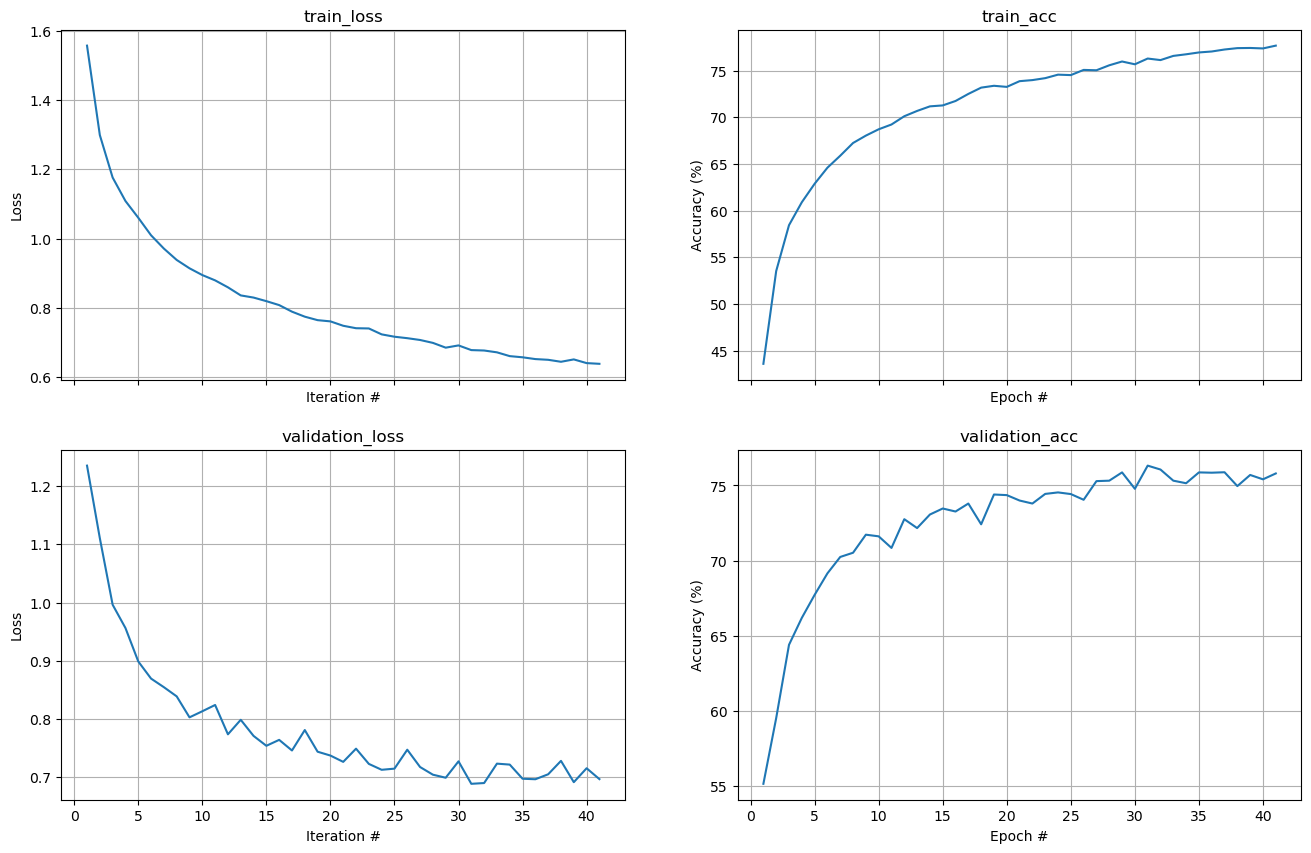

In [12]:

if os.path.isfile(f'{checkpoint_file_final}.pt'):
    print(f'*** Loading final checkpoint file {checkpoint_file_final} instead of training')
    checkpoint_file = checkpoint_file_final
else:
    res = trainer.fit(dl_train, dl_val,
                      num_epochs=EPOCHS, early_stopping=10, print_every=5,
                      checkpoints=checkpoint_file,)
    plot_fit(res)

# Evaluation

##  2. Quantitative Results

*** results from best model:


C:\Users\matan\AppData\Local\Temp\ipykernel_23572\309677174.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  saved_state = torch.load(f'{checkpoint_file}.pt', map_locatio

(<Figure size 1600x1000 with 4 Axes>,
 array([<Axes: title={'center': 'train_loss'}, xlabel='Iteration #', ylabel='Loss'>,
        <Axes: title={'center': 'train_acc'}, xlabel='Epoch #', ylabel='Accuracy (%)'>,
        <Axes: title={'center': 'validation_loss'}, xlabel='Iteration #', ylabel='Loss'>,
        <Axes: title={'center': 'validation_acc'}, xlabel='Epoch #', ylabel='Accuracy (%)'>],
       dtype=object))

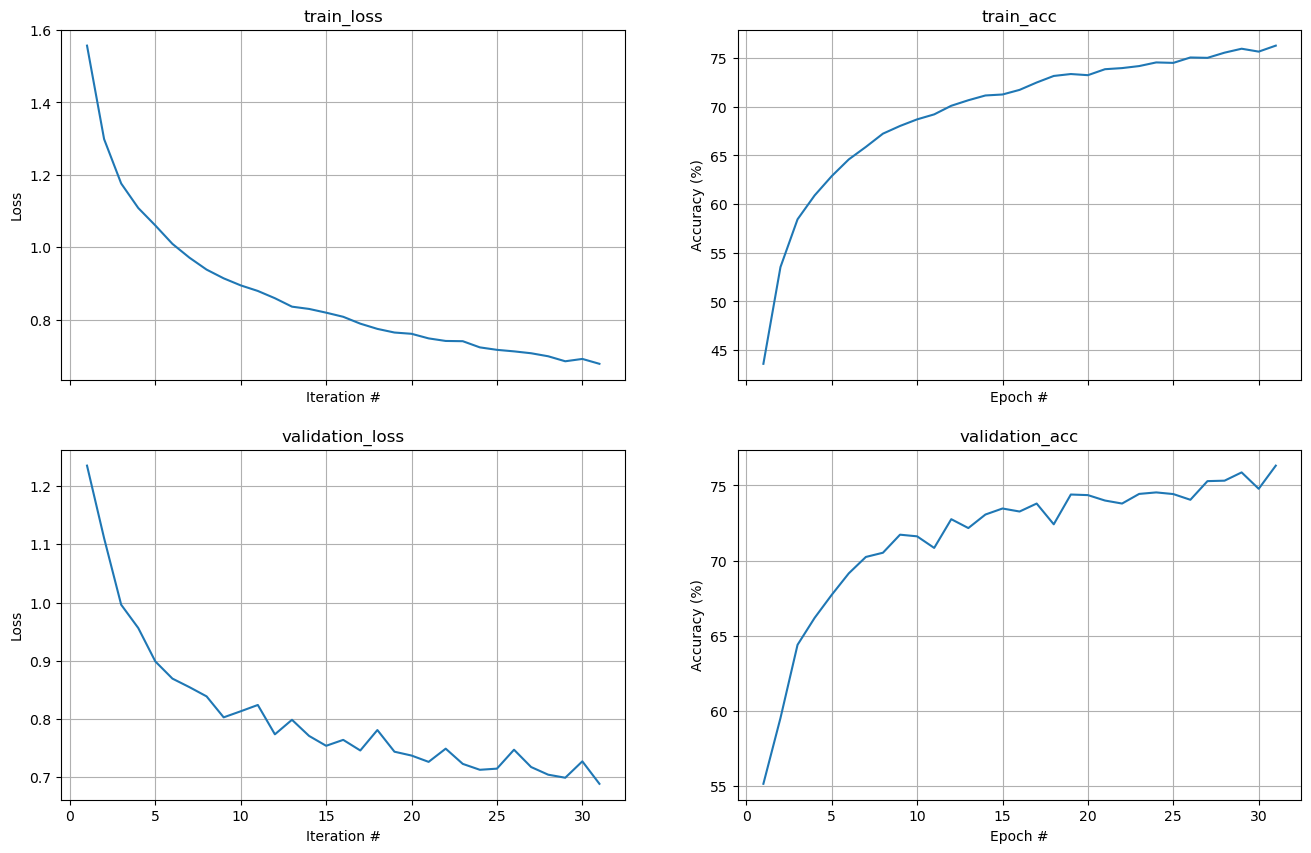

In [13]:
print('*** results from best model:')
saved_state = torch.load(f'{checkpoint_file}.pt', map_location=args.device)
res = saved_state['fit_result']
plot_fit(res)   

In [14]:
res = trainer.test_epoch(dl_test)
print(f'Accuracy on test set: {res.accuracy:.2f}')

test_batch (Avg. Loss 0.716, Accuracy 75.7): 100%|██████████| 313/313 [00:03<00:00, 87.35it/s]
Accuracy on test set: 75.69


## 5. t-SNE

In [ ]:
img_file = f"tsne_images/{checkpoint_file.replace('checkpoints/','')}"
if not os.path.isfile(f'{img_file}_latent_tsne.png'):
    plot_tsne(classifier.encoder, dl_test, args.device, img_file)

c:\Users\matan\.conda\envs\cs236781-tutorials\lib\site-packages\sklearn\manifold\_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
c:\Users\matan\.conda\envs\cs236781-tutorials\lib\site-packages\sklearn\manifold\_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
c:\Users\matan\.conda\envs\cs236781-tutorials\lib\site-packages\sklearn\manifold\_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
c:\Users\matan\.conda\envs\cs236781-tutorials\lib\site-packages\sklearn\manifold\_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


: 